<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/aella_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# aella datasets  
https://knowingless.com/raw-data/  

In [ ]:
!pip install adjustText
!pip install catboost

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from adjustText import adjust_text

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
project_dir = 'drive/My Drive/aella-data'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
os.listdir(project_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['kinkinterestpublic.csv', 'taboo-ratings.csv']

In [ ]:
taboo = pd.read_csv(f'{project_dir}/taboo-ratings.csv')
taboo.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-11-4ce9138308e2>:1: DtypeWarning: Columns (2,19,231,288,289,294,297,300,303,305,308) have mixed types. Specify dtype option on import or set low_memory=False.
  taboo = pd.read_csv(f'{project_dir}/taboo-ratings.csv')


(4514, 314)

In [ ]:
taboo.columns.values

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array(['Run', 'Program Version', 'User', 'Time Started (UTC)',
       'Time Finished (UTC)', 'Minutes Spent', 'Position', 'Points',
       'arousalScale', 'Your age? (rkkox57)', 'selfage',
       'Which category fits you best? (4790ydl)', 'biomale', 'gendermale',
       'cis', 'gendered', 'You got to this survey from: (mpjxl34)',
       'Is this your first time taking the survey? (o8uwpe)', 'firsttime',
       'Randomize (ghojbjt)', 'sexual teasing (vdrdwok)', 'teasing',
       'vaginal sex (with a penis or penile-toy) (nejpuy2)', 'normalsex',
       'anal sex (o282uc7)', 'analsex', 'prepubescent children (53ggvq3)',
       'pedophilia', 'having sex with an anonymous stranger (4296bnp)',
       'anonsex', 'CGL (caregiver/little) dynamics (20uachz)', 'cgl',
       'specific sensory textures (38zk5a)', 'textures',
       'sexual scenarios involving specific roles (like secretaries, nurses, catgirls, etc.) (4odx2pm)',
       'roles',
       'sexual scenarios involving a specific state of 

In [ ]:
df = pd.read_csv(f'{project_dir}/kinkinterestpublic.csv')
df = df.drop('Unnamed: 0',axis=1)
df = df.loc[df['selfage']>=18].copy()
df = df.loc[df['selfage']<=df['selfage'].quantile(.99)]
df['n_kinks'] = df.loc[:, kink_cols].replace(0, np.nan).count(axis=1)
df.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(57300, 133)

In [ ]:
df.columns.values

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array(['Unnamed: 0', 'Minutes Spent', 'gendermale', 'biomale', 'selfage',
       'cis', 'feedism', 'necrophilia', 'receivepain', 'overweight',
       'analsex', 'WAM', 'breastmilk', 'humiliation', 'rapeplay',
       'masculinity', 'masturbatingasfemale', 'multiplepartners',
       'gendertransform', 'femininity', 'genderplay', 'hypnotism',
       'skirts', 'ethnicities', 'roles', 'brothersister', 'dolls',
       'bestiality', 'precum', 'gratification', 'clothing', 'subtype',
       'freeuse', 'badends', 'paintoys', 'clinical', 'bimbos',
       'sadomasochism', 'textures', 'dirty', 'smallclothing', 'beingsub',
       'sissification', 'cunnilingus', 'creepycrawlies', 'toys',
       'animaltransform', 'tickling', 'genderswapped', 'mindbreak',
       'makeouts', 'feet', 'armpits', 'frustration', 'bukkake',
       'sizediff', 'pegging', 'pedophilia', 'creepy', 'tailsandhorns',
       'cuckoldry', 'beingdom', 'smells', 'futa', 'givepain',
       'teacherstudent', 'obedience', 'blowjobs', 'my

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

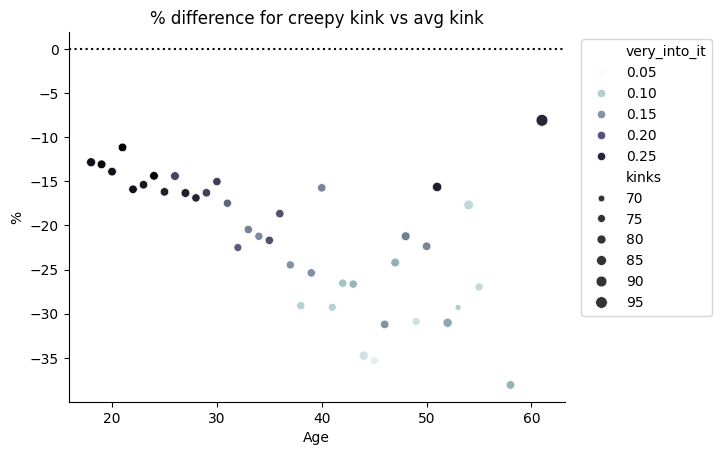

In [ ]:
col = np.random.choice(df.columns.values)
person_cols = ['Minutes Spent', 'gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']
kink_cols = [x for x in df.columns.values if x not in person_cols]
df_plt = df.loc[:, ['selfage']+kink_cols].replace(0,np.nan).groupby('selfage', as_index=False).mean()
_df_plt = df.loc[df[col]>0, ['selfage', 'n_kinks']].groupby('selfage', as_index=False).mean()
df_plt = pd.melt(df_plt,id_vars='selfage')
_df_plt = pd.melt(_df_plt,id_vars='selfage', value_name='kinks')
df_plt = df_plt.merge(_df_plt.drop('variable',axis=1))
df_plt_base = df.loc[:, ['selfage']+kink_cols].replace(0,np.nan).groupby('selfage', as_index=False).mean()
df_plt_base['avg'] = df_plt_base.loc[:, kink_cols].mean(axis=1)
df_plt_base.loc[:, ['selfage','avg']]
df_plt = df_plt.merge(df_plt_base)
df_plt['%diff'] = ((df_plt['value'].sub(df_plt['avg'])).div(df_plt['avg'])).mul(100)
_df_plt1 = df.loc[df[col]>3, ['selfage', col]].groupby('selfage', as_index=False).count()
_df_plt2 = df.loc[df[col]>0, ['selfage', col]].groupby('selfage', as_index=False).count()
_df_plt1 = _df_plt1.merge(_df_plt2, on=['selfage'])
_df_plt1[col] = _df_plt1[f'{col}_x'].div(_df_plt1[f'{col}_y'])
df_plt = df_plt.merge(_df_plt1.loc[:, ['selfage',col]].rename(columns={col:'very_into_it'}))
sns.scatterplot(data=df_plt.loc[df_plt['variable']==col], x='selfage', y='%diff',
                hue='very_into_it', palette='bone_r', size='kinks')
plt.axhline(0, ls=':', c='k')
plt.title(f"% difference for {col} kink vs avg kink")
sns.despine()
plt.xlabel('Age')
plt.ylabel('%')
plt.legend(bbox_to_anchor=(1.02,1),loc=2)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, mean_squared_error
import catboost as cb

person_cols = ['Minutes Spent', 'gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']
kink_cols = [x for x in df.columns.values if x not in person_cols]
target = 'armpits'
target_clf = f'{target}%'
# feats = ['gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']+kink_cols
feats = ['gendermale', 'biomale', 'selfage', 'cis', 'n_kinks']+[x for x in kink_cols if x!=target]


model_data = df.loc[:, feats+[target]].fillna(-1)
model_data[f'{target}%'] = 0
model_data['model2'] = 0
model_data.loc[model_data[target]>0,f'{target}%'] = 1
model_data.loc[model_data[f'{target}']>0, 'model2'] = 1

folds = 3
kf = KFold(folds, shuffle=True)
clf = pd.Series()
score = pd.Series()
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(learning_rate=0.001, verbose=False)
  model.fit(train.loc[:, feats], train[target_clf])
  s = pd.DataFrame(model.predict_proba(test.loc[:, feats]), index=test.index)[1]
  clf = pd.concat([clf,s])

  train2 = train.loc[train['model2']==1].copy()
  # test2 = test.loc[test['model2']==1].copy()
  model = cb.CatBoostRegressor(learning_rate=0.001, verbose=False)
  model.fit(train2.loc[:, feats], train2[target])
  s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
  score = pd.concat([score,s])

model_data[f'{target}%_pred'] = clf
model_data[f'{target}_pred'] = score



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-162-7f2feaed12d1>:21: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clf = pd.Series()
<ipython-input-162-7f2feaed12d1>:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  score = pd.Series()


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
[
    log_loss(model_data[f'{target}%'],model_data[f'{target}%_pred']),
    mean_squared_error(model_data[f'{target}'],model_data[f'{target}_pred'])**0.5,
]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0.40299993385187577, 2.2268507996126954]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

count    57300.000000
mean         0.295978
std          0.198238
min          0.064114
25%          0.095989
50%          0.257459
75%          0.443473
max          0.807421
Name: armpits%_pred, dtype: float64

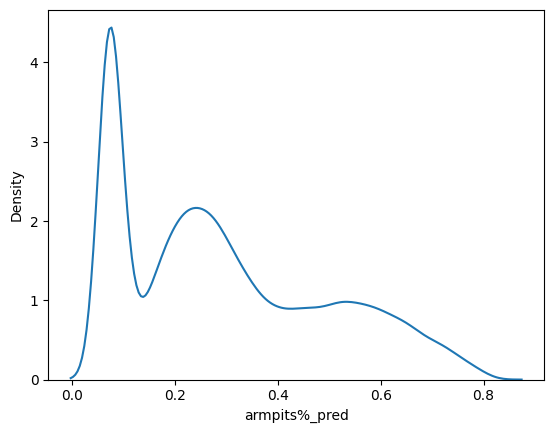

In [ ]:
sns.kdeplot(model_data[f"{target}%_pred"])
model_data[f"{target}%_pred"].describe()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

count    11395.000000
mean         2.377904
std          0.376988
min          1.920709
25%          2.082921
50%          2.281710
75%          2.560644
max          3.877975
Name: armpits_pred, dtype: float64

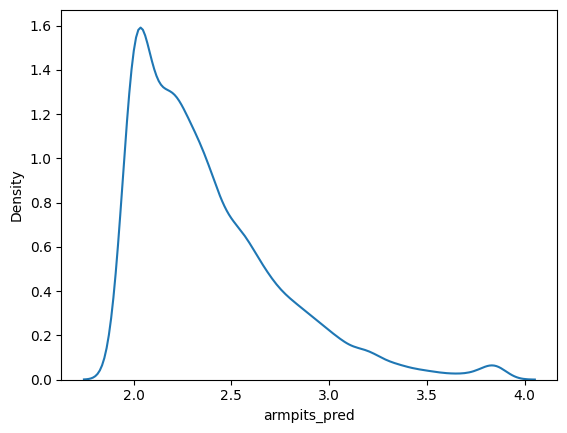

In [ ]:
sns.kdeplot(model_data.loc[model_data[f'{target}%_pred']>.5, f'{target}_pred'])
model_data.loc[model_data[f'{target}%_pred']>.5, f'{target}_pred'].describe()

In [ ]:
ranks = model_data.loc[model_data[f'{target}%_pred']>.5, kink_cols].mean().sort_values(ascending=False)
ranks[ranks>0].head(50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

femininity              4.367705
sensuality              4.048618
blowjobs                4.045546
makeouts                4.026152
cunnilingus             3.870645
teasing                 3.868188
lips                    3.814305
skirts                  3.768144
toys                    3.656955
romance                 3.639228
gentleness              3.503817
analsex                 3.491005
masturbatingasfemale    3.442036
multiplepartners        3.381659
roles                   3.359719
spanking                3.337604
clothing                3.322071
beingdom                3.312944
beingsub                3.278894
frustration             3.268890
anonsex                 3.250724
largebreasts            3.229048
freeuse                 3.212462
teacherstudent          3.209127
squirt                  3.170250
obedience               3.157262
exhibitionism           3.144800
masterslave             3.120842
voyeurism               3.076700
smallclothing           3.010355
choking   

In [ ]:
ranks = model_data.loc[(model_data[f'{target}%_pred']>.5) & (model_data[f'{target}_pred']>3), kink_cols].mean().sort_values(ascending=False)
ranks[ranks>0].head(50)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

smells                  4.701330
femininity              4.590085
teasing                 4.540508
feet                    4.524788
blowjobs                4.512696
analsex                 4.503023
makeouts                4.448609
sensuality              4.438936
cunnilingus             4.432890
lips                    4.429262
toys                    4.409915
obedience               4.403869
clothing                4.388150
skirts                  4.360339
masterslave             4.357920
urine                   4.351874
beingsub                4.336155
frustration             4.331318
roles                   4.326481
multiplepartners        4.287787
squirt                  4.281741
spanking                4.270859
exhibitionism           4.262394
choking                 4.221282
sadomasochism           4.197098
humiliation             4.195889
teacherstudent          4.182588
masturbatingasfemale    4.175333
precum                  4.162031
mindbreak               4.152358
smallcloth